# Bead-spring model

In [1]:
import sys

sys.path.append('..')

In [2]:
from argparse import Namespace

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy import stats
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
from misc.sampler import CartesianSampler
from toy.bead_spring import del_medium_etpy, del_shannon_etpy, simulation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle

import torchvision.datasets as dsets
import torchvision.transforms as transforms



%config InlineBackend.figure_format = 'retina'

## NEEP 

In [3]:
class NEEP(nn.Module):
    def __init__(self, opt):
        super(NEEP, self).__init__()
        self.h = nn.Sequential(
            nn.Linear(2*opt.n_input, opt.n_hidden),
            nn.ReLU(inplace=True),
#            nn.Dropout(0.1),
            nn.Linear(opt.n_hidden, opt.n_hidden),
            nn.ReLU(inplace=True),
#            nn.Dropout(0.1),
            nn.Linear(opt.n_hidden, opt.n_hidden),
            nn.ReLU(inplace=True),
#            nn.Dropout(0.1),
            nn.Linear(opt.n_hidden, 1)
        )

    def forward(self, s1, s2):
        x = torch.cat([s1, s2], dim=-1)
        _x = torch.cat([s2, s1], dim=-1)
        # Equation (1) in the paper
        
        return self.h(x) - self.h(_x) 

### Training Algorithm

In [4]:
def train1(opt, model, optim, trajs, sampler):
    model.train()
    batch, next_batch = next(sampler)

    s_prev = trajs[batch].to(opt.device)
    s_next = trajs[next_batch].to(opt.device)
    ent_production = model(s_prev, s_next)
    optim.zero_grad()
    
    # The objective function J. Equation (2)
    loss = (-ent_production + torch.exp(-ent_production)).mean()
    loss.backward()
    optim.step()
    return loss.item()



def validate(opt, model, trajs, sampler):
    model.eval()

    ret = []
    loss = 0
    with torch.no_grad():
        for batch, next_batch in sampler:
            s_prev = trajs[batch].to(opt.device)
            s_next = trajs[next_batch].to(opt.device)
            
            ent_production = model(s_prev, s_next)
            entropy = ent_production.cpu().squeeze().numpy()
            ret.append(entropy)
            loss += (- ent_production + torch.exp(-ent_production)).sum().cpu().item()
    loss = loss / sampler.size
    ret = np.concatenate(ret)
    ret = ret.reshape(trajs.shape[0], trajs.shape[1]-1)
    return ret, loss

### Hyper-parameters

In [5]:
opt = Namespace()
opt.device = 'cuda:0' 
opt.batch_size = 4096
opt.test_batch_size = 5000
opt.n_input = 2
opt.n_hidden = 300
opt.dropout_probability = 0.1

opt.lr = 0.0001
opt.wd = 5e-5

opt.record_freq = 1000
opt.seed = 398

torch.manual_seed(opt.seed)

# Trajectory sampling

In [6]:
opt.M = 100          # number of trajectories
opt.L = 2000         # lenth of a trjectory 
opt.n_beads = 2       # number of beads
opt.Tc = 1            # cold temperature
opt.Th = 10           # hot temperature 
opt.time_step = 0.01  # time step size for Langevin simulation

#trajs = simulation(opt.M, opt.L, opt.n_beads, opt.Tc, opt.Th, opt.time_step, seed=0)
#test_trajs = simulation(opt.M, opt.L, opt.n_beads, opt.Tc, opt.Th, opt.time_step, seed=1)
with open('data100_2000.pickle', 'rb') as f:
    trj1 = pickle.load(f)
with open('data100_2000_t.pickle', 'rb') as f:
    trj2 = pickle.load(f)

trajs = trj1
test_trajs = trj2


trajs_t = trajs.to(opt.device).float()
test_trajs_t = test_trajs.to(opt.device).float()

In [7]:
"""with open('data11.pickle', 'rb') as f:
    trj1 = pickle.load(f)
with open('data22.pickle', 'rb') as f:
    trj2 = pickle.load(f)

trajs = trj1
test_trajs = trj2"""

"with open('data11.pickle', 'rb') as f:\n    trj1 = pickle.load(f)\nwith open('data22.pickle', 'rb') as f:\n    trj2 = pickle.load(f)\n\ntrajs = trj1\ntest_trajs = trj2"

## Build model & Training

In [8]:
model = NEEP(opt)
model = model.to(opt.device)
optim = torch.optim.Adam(model.parameters(), opt.lr, weight_decay=opt.wd)
#model.load_state_dict(torch.load('train_savepoint10000_50_400.pth'))


train_sampler = CartesianSampler(opt.M, opt.L, opt.batch_size, device=opt.device)
test_sampler = CartesianSampler(opt.M, opt.L, opt.test_batch_size, device=opt.device, train=False)

# NEEP outputs before training begin
preds_untrained, _ = validate(opt, model, test_trajs_t, test_sampler)

# Analytic EP
ents = del_medium_etpy(test_trajs[:2], 1, 10) + del_shannon_etpy(test_trajs[:2], 1, 10)

In [9]:
def plot_scatter(pred, ent):
    pred_rate, _, r_value, pvalue, _  = stats.linregress(ent, pred)
    plt.figure(figsize=(4,4), dpi=100)
    sns.regplot(ent, pred,
                color='C3', 
                line_kws={
                    'lw':1.5,
                    'label':'$R^2=%.4f$ p-value: %.4f' %(r_value**2, pvalue)},
                scatter_kws={
                    'color':'grey', 
                    'alpha':0.3, 
                    's':3, 
                    'rasterized':True})
    plt.xlabel('$\Delta S$', fontsize=12)
    plt.ylabel('$\Delta S_{\\theta}$', fontsize=12)
    plt.legend()

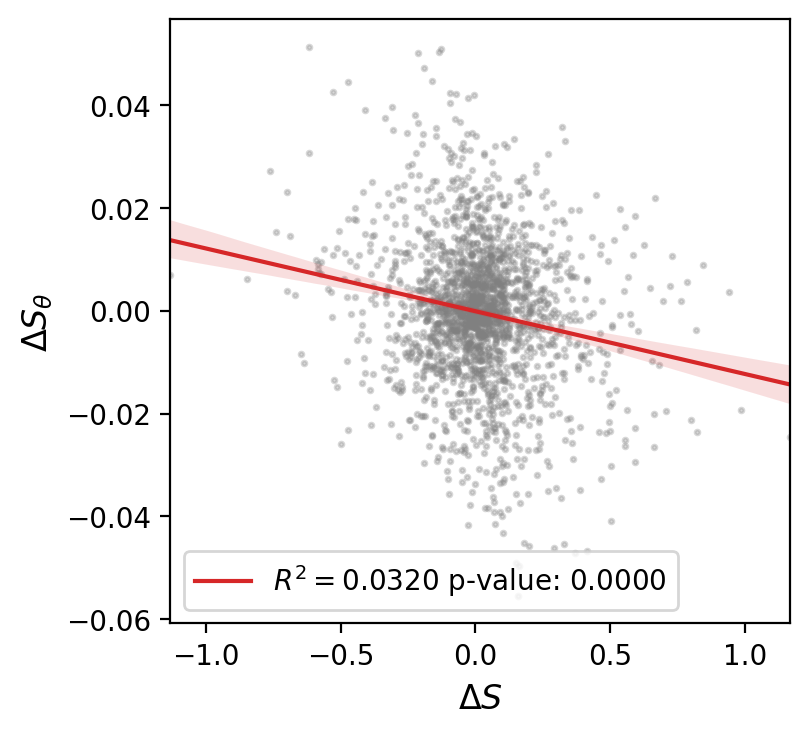

In [10]:
pred = preds_untrained[1]
ent = ents[1]
plot_scatter(pred, ent)


In [11]:
opt.n_iter = 1000 # number of training iteration
effective_num = 20

num = 100 # number of models
loss_val = torch.zeros(opt.n_iter+1)
gen_ep = np.zeros((effective_num, opt.L-1))
gen_ep_tr = np.zeros((effective_num, opt.L-1))
bias_array = np.zeros((effective_num, opt.L-1))
variance_array = np.zeros(effective_num)
pred_m = np.zeros((num,effective_num,opt.L-1))

tr_pre_te = np.zeros((num,effective_num,opt.L-1))

R2_value = np.zeros(effective_num)

a = 0


for k in tqdm(range(effective_num)):
    opt.n_hidden = opt.n_hidden + 20
    
    for j in tqdm(range(num)):
        model = NEEP(opt)
        #model.load_state_dict(torch.load('train_savepoint8_200000_50_400.pth'))
        model = model.to(opt.device)
        optim = torch.optim.Adam(model.parameters(), opt.lr, weight_decay=opt.wd)
        
        for i in tqdm(range(1, opt.n_iter + 1)):
            train1(opt, model, optim, trajs_t, train_sampler)
            
            if i ==  opt.n_iter:
                preds, _ = validate(opt, model, test_trajs_t, test_sampler)
                pred = preds[1]
                pred_m[j,a,:] = pred


                gen_ep[a,:] = gen_ep[a,:] + pred

                pred_rate, _, r_value, pvalue, _  = stats.linregress(ent, pred)
                R2_value[a] += r_value**2
    a+=1
            
            
        #loss_val[i] = train(opt, model, optim, trajs_t, train_sampler)

  #  if j==num:
  #      torch.save(model.state_dict(),'train_savepoint_20000_64.pth')
    
R2_value = R2_value/num
gen_ep = gen_ep/num


            
        #loss_val[i] = train(opt, model, optim, trajs_t, train_sampler)

  #  if j==num:
  #      torch.save(model.state_dict(),'train_savepoint_20000_64.pth')

In [12]:
#torch.save(model.state_dict(),'train_savepoint10000_50_400.pth')

In [13]:
print(R2_value)

[0.95832236 0.95845728 0.95720386 0.9555893  0.95578058 0.95435519
 0.95331549 0.9533426  0.95205929 0.95153651 0.9526578  0.95200487
 0.9518755  0.9494052  0.95102627 0.95002426 0.94904932 0.94810642
 0.95039834 0.94953559]


20
300.0


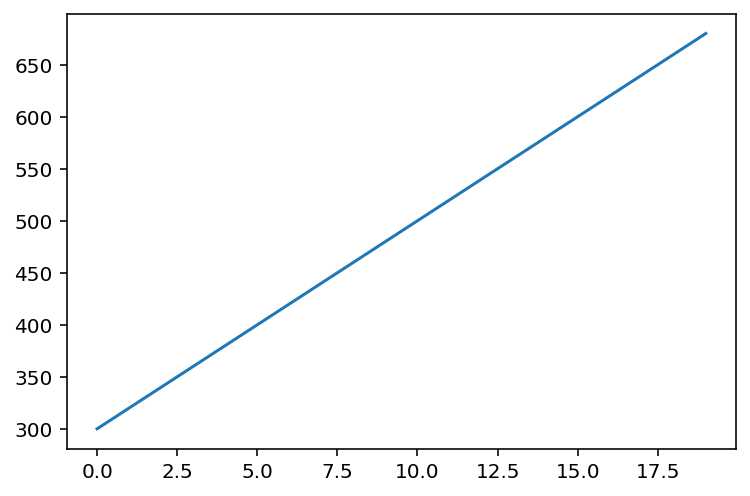

In [25]:
lenx = effective_num
lenx = int(lenx)
print(lenx)
x_axis = np.zeros(lenx)
for i in range(lenx):
    x_axis[0] =300
    x_axis[i] = x_axis[i-1] + 20

plt.plot(x_axis)
print(x_axis[0])

In [15]:
bias_array = np.zeros(effective_num)

for i in range(effective_num):
    for j in range(opt.L-1):
        bias_array[i] += (gen_ep[i,j]-ent[j])**2
   # bias_array[i]=bias_array[i]
    

In [16]:
print(gen_ep.shape)
print(pred_m.shape)

(20, 1999)
(100, 20, 1999)


Text(0.5, 1.0, 'Epoch 5000, Width 300-700 - $R^2 Value$')

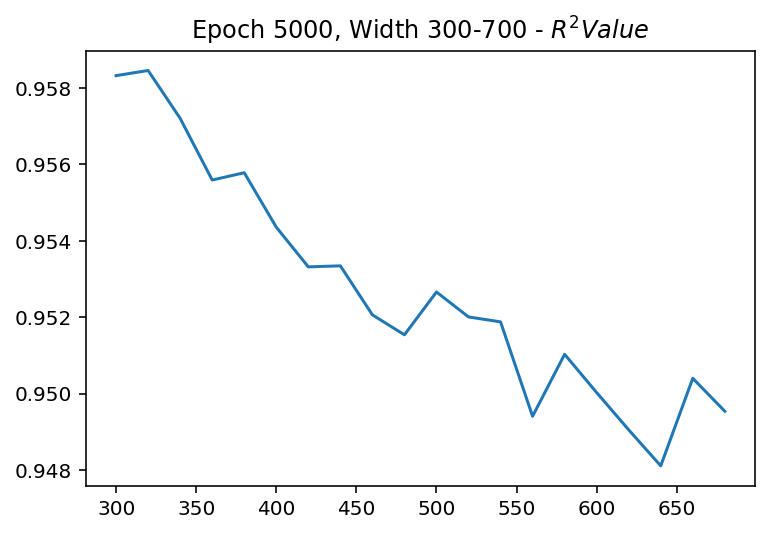

In [28]:
plt.plot(x_axis, R2_value, label = 'error')
plt.title('Epoch 5000, Width 300-700 - $R^2 Value$')


In [18]:
variance_array = np.zeros(effective_num)
tr_te = np.zeros(effective_num)



vara = np.zeros((num, effective_num))
mid_vari = np.zeros((num,effective_num))

for i in range(num):
    for j in range(opt.L-1):
        mid_vari[i,:] += (pred_m[i,:,j]-gen_ep[:,j])**2

variance_array = np.sum(mid_vari, axis=0)/num
#for i in range(effective_num):
#    for j in range(opt.L-1):
    #    k[i,j] = mid_vari[i,j]**2
        #variance_array[i] = 

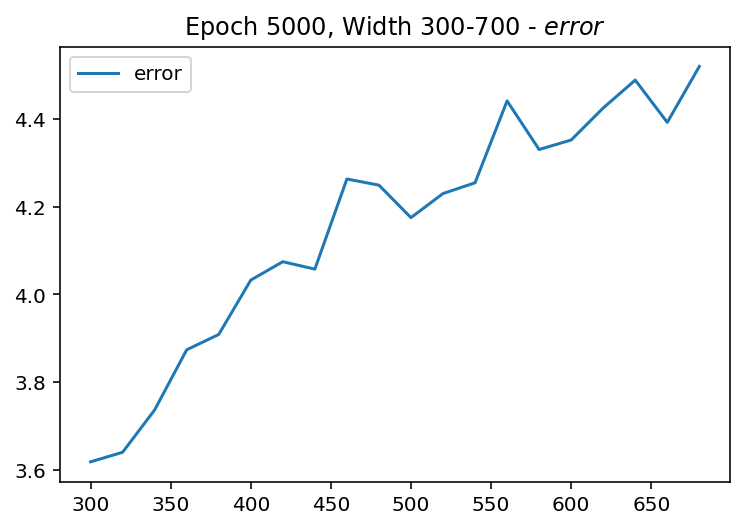

In [29]:
gen_error = np.zeros(effective_num)
for i in range(effective_num):
    gen_error[i] = variance_array[i]+bias_array[i]
    
plt.plot(x_axis, gen_error, label = 'error')
plt.title('Epoch 5000, Width 300-700 - $error$')

plt.legend()


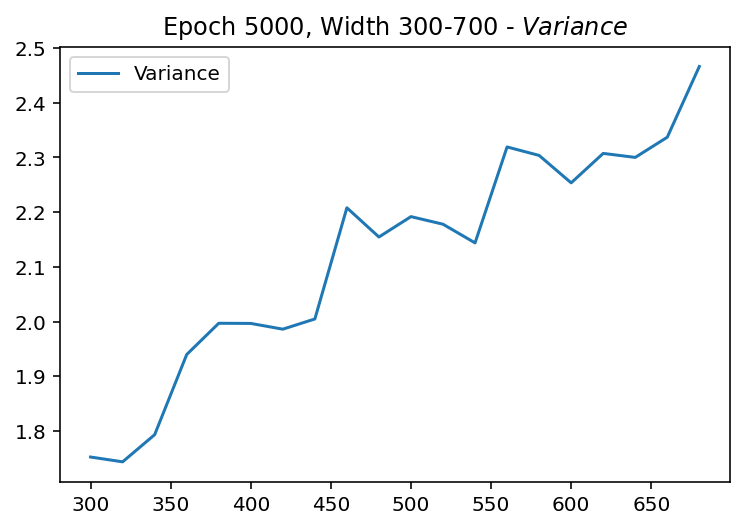

In [31]:
plt.plot(x_axis, variance_array, label = 'Variance')
plt.title('Epoch 5000, Width 300-700 - $Variance$')


plt.legend()

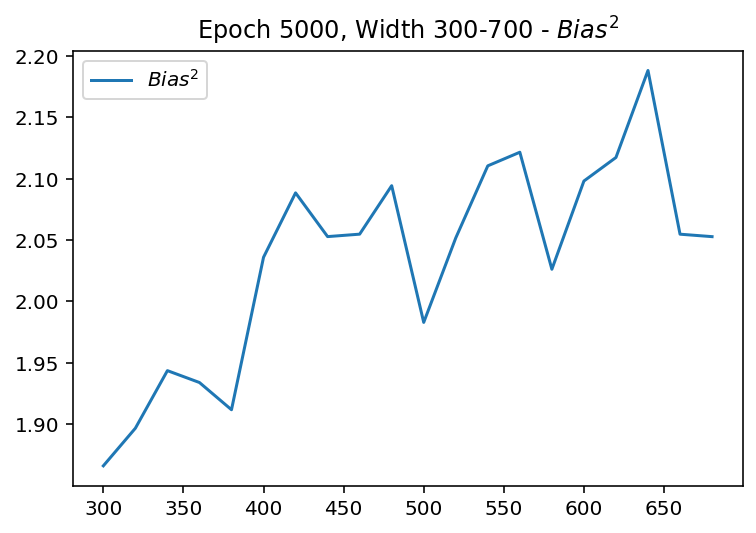

In [32]:
plt.plot(x_axis, bias_array, label = '$Bias^2$')
plt.title('Epoch 5000, Width 300-700 - $Bias^2$')


plt.legend()

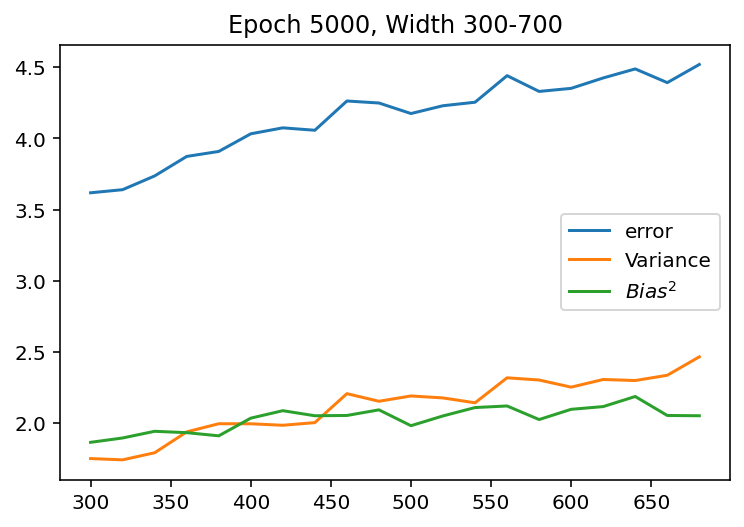

In [33]:

plt.plot(x_axis, gen_error, label = 'error')
plt.plot(x_axis, variance_array, label = 'Variance')
plt.plot(x_axis, bias_array, label = '$Bias^2$')
plt.title('Epoch 5000, Width 300-700')


plt.legend()




In [23]:


    
"""
with open('C_rvalue100_2000_5000_width100_500.pickle', 'wb') as f:
    pickle.dump(R2_value, f, pickle.HIGHEST_PROTOCOL)
with open('C_Bias100_2000_5000_width100_500.pickle', 'wb') as f:
    pickle.dump(bias_array, f, pickle.HIGHEST_PROTOCOL)
with open('C_Variance100_2000_5000_width100_500.pickle', 'wb') as f:
    pickle.dump(variance_array, f, pickle.HIGHEST_PROTOCOL)
with open('C_Error100_2000_5000_width100_500.pickle', 'wb') as f:
    pickle.dump(gen_error, f, pickle.HIGHEST_PROTOCOL)
    """

"\nwith open('C_rvalue100_2000_5000_width100_500.pickle', 'wb') as f:\n    pickle.dump(R2_value, f, pickle.HIGHEST_PROTOCOL)\nwith open('C_Bias100_2000_5000_width100_500.pickle', 'wb') as f:\n    pickle.dump(bias_array, f, pickle.HIGHEST_PROTOCOL)\nwith open('C_Variance100_2000_5000_width100_500.pickle', 'wb') as f:\n    pickle.dump(variance_array, f, pickle.HIGHEST_PROTOCOL)\nwith open('C_Error100_2000_5000_width100_500.pickle', 'wb') as f:\n    pickle.dump(gen_error, f, pickle.HIGHEST_PROTOCOL)\n    "

In [24]:
#variance_array = np.zeros(effective_num)
#tr_te = np.zeros(effective_num)



#vara = np.zeros((num, effective_num))
#mid_vari = np.zeros((num,effective_num))

#for i in range(num):
#    for j in range(opt.L-1):
#        mid_vari[i,:] += (pred_m[i,:,j]-gen_ep[:,j])**2

#variance_array = np.sum(mid_vari, axis=0)/num
#for i in range(effective_num):
#    for j in range(opt.L-1):
    #    k[i,j] = mid_vari[i,j]**2
        #variance_array[i] = 